In [1]:
# === Частина 0: Імпорти та параметри ===
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from copy import deepcopy
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [ ]:
# Параметри
FILE_PATH = r'D:\university\ML\lab4\synthetic_coffee_health_10000.csv'  
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.25  # відносно train_val -> 0.6/0.2/0.2
MAX_DEPTH_MYTREE = None  # для побудови повного дерева (для pruning ставимо None)
MIN_SAMPLES_SPLIT_MYTREE = 2

np.random.seed(RANDOM_STATE)

In [3]:
# === Частина 1: Завантаження даних та первинна перевірка ===
print('\n=== Частина 1: Завантаження даних ===')
try:
    df = pd.read_csv(FILE_PATH)
    print('Розмір датасету:', df.shape)
except Exception as e:
    raise FileNotFoundError(f"Не вдалося відкрити {FILE_PATH}: {e}")

# Видалення ID (якщо є)
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])
    print('Видалено колонку ID')

print('Колонки:', df.columns.tolist())
print('\nКількість NA по колонкам:')
print(df.isna().sum())

if 'Health_Issues' not in df.columns:
    raise ValueError('У датасеті немає колонки Health_Issues — перевір файл.')

# Видалення рядків без цільової змінної (альтернатива: імпутація)
n_missing_target = df['Health_Issues'].isna().sum()
print('Пропусків у Health_Issues:', n_missing_target)
if n_missing_target > 0:
    df = df.dropna(subset=['Health_Issues']).reset_index(drop=True)
    print('Видалено рядки з відсутньою Health_Issues. Новий розмір:', df.shape)

print('Унікальні класи Health_Issues:', df['Health_Issues'].unique())

# === Частина 2: Інженерія ознак і кодування ===
print('\n=== Частина 2: Інженерія ознак та кодування ===')

# Категоріальні (як у вимогах)
cat_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation', 'Smoking', 'Alcohol_Consumption']
cat_cols = [c for c in cat_cols if c in df.columns]

# Числові колонки
num_cols = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']
num_cols = [c for c in num_cols if c in df.columns]

# Створюємо interaction та бінування віку
if set(['Coffee_Intake', 'Sleep_Hours']).issubset(df.columns):
    df['Coffee_Sleep'] = df['Coffee_Intake'] * df['Sleep_Hours']
    print('Створено Coffee_Sleep')

if 'Age' in df.columns:
    df['Age_bin'] = pd.cut(df['Age'], bins=[0, 30, 50, 80, 120], labels=['Young', 'Mid', 'Senior', 'Old'])
    cat_cols.append('Age_bin')
    print('Додано Age_bin')

# One-hot для категоріальних
print('Категоріальні для one-hot:', cat_cols)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)
print('Форма після one-hot:', df_encoded.shape)

# X, y
y = df_encoded['Health_Issues'].astype(str)
X = df_encoded.drop(columns=['Health_Issues'])

# Масштабування числових колонок
scaler = StandardScaler()
num_cols_present = [c for c in num_cols if c in X.columns]
if num_cols_present:
    X[num_cols_present] = scaler.fit_transform(X[num_cols_present])
    print('Стандартизовано числові фічі:', num_cols_present)

# Кодуємо y
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Класи (label encoder):', le.classes_)


=== Частина 1: Завантаження даних ===
Розмір датасету: (10000, 16)
Видалено колонку ID
Колонки: ['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']

Кількість NA по колонкам:
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64
Пропусків у Health_Issues: 5941
Видалено рядки з відсутньою Health_Issues. Новий розмір: (4059, 15)
Унікальні класи Health_Issues: ['Mild' 'Moderate' 'Severe']



In [4]:
# === Частина 3: Розбиття на train/val/test зі стратифікацією ===
print('\n=== Частина 3: Розбиття на train/val/test ===')
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_enc, test_size=TEST_SIZE, stratify=y_enc, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VAL_SIZE, stratify=y_train_val, random_state=RANDOM_STATE)

print('Розміри: X_train', X_train.shape, 'X_val', X_val.shape, 'X_test', X_test.shape)


=== Частина 3: Розбиття на train/val/test ===
Розміри: X_train (2435, 51) X_val (812, 51) X_test (812, 51)


In [5]:
# === Частина 4: Реалізація MyDecisionTree (Gini + importance) ===
print('\n=== Частина 4: Реалізація MyDecisionTree ===')
class MyDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_importance = None
        self.tree = None
        self.n_total = None

    def gini(self, y):
        m = len(y)
        if m == 0:
            return 0.0
        counts = np.bincount(y)
        probs = counts / m
        return 1.0 - np.sum(probs ** 2)

    def weighted_gini(self, y_left, y_right):
        n_left, n_right = len(y_left), len(y_right)
        n = n_left + n_right
        if n == 0:
            return 0.0
        return (n_left / n) * self.gini(y_left) + (n_right / n) * self.gini(y_right)

    def best_split(self, X, y):
        n_samples, n_features = X.shape
        best_feature, best_threshold = None, None
        best_gini = float('inf')
        parent_gini = self.gini(y)

        for feature in range(n_features):
            vals = X[:, feature]
            if np.all(vals == vals[0]):
                continue
            
            sorted_idx = np.argsort(vals)
            vals_sorted = vals[sorted_idx]
            y_sorted = y[sorted_idx]

            for i in range(1, n_samples):
                if vals_sorted[i] == vals_sorted[i-1]:
                    continue
                
                thr = (vals_sorted[i] + vals_sorted[i-1]) / 2.0
                left_mask = vals <= thr
                y_left = y[left_mask]
                y_right = y[~left_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                wg = self.weighted_gini(y_left, y_right)
                
                if wg < best_gini:
                    best_gini = wg
                    best_feature = feature
                    best_threshold = thr
        
        if best_feature is None:
            return None, None, 0.0
        
        return best_feature, best_threshold, (parent_gini - best_gini)

    def majority_class(self, y):
        cnt = Counter(y)
        return cnt.most_common(1)[0][0]

    def build_tree(self, X, y, depth=0):
        node = {}
        n_samples = X.shape[0]
        num_classes = len(np.unique(y))
        
        # критерії зупинки
        if (self.max_depth is not None and depth >= self.max_depth) or (n_samples < self.min_samples_split) or (num_classes == 1):
            node['leaf'] = True
            node['class'] = self.majority_class(y)
            node['n_node'] = n_samples
            return node
        
        best_feature, best_threshold, gini_decrease = self.best_split(X, y)
        
        if best_feature is None or gini_decrease <= 0:
            node['leaf'] = True
            node['class'] = self.majority_class(y)
            node['n_node'] = n_samples
            return node
        
        node['leaf'] = False
        node['feature'] = best_feature
        node['threshold'] = best_threshold
        node['n_node'] = n_samples
        
        # акумулюємо importance (зважено на розмір вузла)
        self.feature_importance[best_feature] += (n_samples / self.n_total) * gini_decrease
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        node['left'] = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        node['right'] = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return node

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).astype(int)
        self.n_total = len(y)
        self.feature_importance = np.zeros(X.shape[1])
        self.tree = self.build_tree(X, y, depth=0)
        
        s = np.sum(self.feature_importance)
        if s > 0:
            self.feature_importance = self.feature_importance / s
        
        return self

    def predict_one(self, x, node=None):
        if node is None:
            node = self.tree
        
        if node.get('leaf', False):
            return node['class']
        
        f = node['feature']
        thr = node['threshold']
        
        if x[f] <= thr:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X, node=None):
        X = np.asarray(X)
        if node is None:
            node = self.tree
        preds = [self.predict_one(x, node) for x in X]
        return np.array(preds)

    # --- Методи для pruning на валідаційній вибірці ---
    def _get_indices_reaching_node(self, X, node):
        # повертає маску (булевий масив) для X, які досягають даного node
        mask = np.zeros(X.shape[0], dtype=bool)
        
        # Це складно без посилань на батьків; простіше — перевіряти для кожного рядка шлях
        for i in range(X.shape[0]):
            cur = self.tree
            reached = False
            
            while True:
                if cur is node:
                    reached = True
                    break
                
                if cur.get('leaf', False):
                    break
                
                f = cur['feature']; thr = cur['threshold']
                
                # Примітка: X тут є Pandas DataFrame/Series, X.values дасть numpy array
                # Для коректного індексування потрібно використовувати .values
                if X.values[i, f] <= thr:
                    cur = cur['left']
                else:
                    cur = cur['right']
            
            mask[i] = reached
        return mask

    def _count_leaves(self, node):
        if node.get('leaf', False):
            return 1
        return self._count_leaves(node['left']) + self._count_leaves(node['right'])

    def _calculate_error_on_subset(self, X_sub, y_sub, node):
        if X_sub.shape[0] == 0:
            return 0.0
        # X_sub - це DataFrame/Series, тому використовуємо .values
        preds = self.predict(X_sub.values, node=node)
        return np.sum(preds != y_sub)

    def prune_by_validation(self, X_val, y_val, alpha=0.0):
        """
        Пост-обрізка по валідаційній вибірці для одного alpha.
        Рекурсивно пробує замінити піддерево на лист, якщо це покращує cost := error + alpha * n_leaves
        """
        X_val = X_val.reset_index(drop=True)
        y_val = np.asarray(y_val)
        
        def recurse(node):
            if node.get('leaf', False):
                # Помилка: 0, тому що це лист. Всі, хто доходять до нього, отримують його передбачення.
                # Але треба врахувати, що це помилка на валідаційній підмножині, яка до нього доходить
                # Це викличе перерахунок помилки в _calculate_error_on_subset, що правильно
                return self._calculate_error_on_subset(X_val[self._get_indices_reaching_node(X_val, node)], 
                                                      y_val[self._get_indices_reaching_node(X_val, node)], 
                                                      node), 1 # 1 лист
            
            # індекси валідаційних прикладів, що доходять до цієї ноди
            mask = self._get_indices_reaching_node(X_val, node)
            X_sub = X_val[mask]
            y_sub = y_val[mask]
            
            # обчислимо помилку для піддерева (рекурсивно). Тут потрібен deepcopy ноди.
            # Щоб мати можливість відкотитися, якщо прунінг не вигідний, 
            # або приймати рішення про прунінг на наступних рівнях.
            # *УВАГА*: оригінальна реалізація в коді змінює дерево in-place, що вимагає deepcopy 
            # перед рекурсивним викликом, якщо ми не хочемо, щоб зміни в дочірніх нодах впливали 
            # на рішення про прунінг у батьківській ноді. Оскільки у нас є зовнішній цикл з 
            # `prune_with_alpha_grid`, ми *покладаємося* на те, що він робить `deepcopy` 
            # до виклику цієї функції.
            
            left_err, left_leaves = recurse(node['left'])
            right_err, right_leaves = recurse(node['right'])
            
            subtree_error = left_err + right_err
            subtree_leaves = left_leaves + right_leaves
            
            # якщо замінити на лист -> majority class в цьому піддереві
            if X_sub.shape[0] == 0:
                # немає валідаційних прикладів — не обрізаємо
                return subtree_error, subtree_leaves
            
            # Важливо: majoriy class беремо з y_sub (валідаційна підмножина, що доходить до цієї ноди)
            leaf_class = self.majority_class(y_sub)
            
            # створимо тимчасовий лист
            tmp_leaf = {'leaf': True, 'class': int(leaf_class), 'n_node': X_sub.shape[0]}
            leaf_error = self._calculate_error_on_subset(X_sub, y_sub, tmp_leaf)
            
            # cost
            cost_subtree = subtree_error + alpha * subtree_leaves
            cost_leaf = leaf_error + alpha * 1
            
            if cost_leaf <= cost_subtree:
                # заміняємо поточний вузол на лист
                node.clear()
                node['leaf'] = True
                node['class'] = int(leaf_class)
                node['n_node'] = X_sub.shape[0]
                return leaf_error, 1
            else:
                return subtree_error, subtree_leaves
        
        # *Примітка*: для коректного прунінгу потрібно ітерувати знизу вгору. 
        # Рекурсивний виклик робить це природним чином.
        recurse(self.tree)

    def recompute_importance(self, X_train, y_train):
        # Перекомпонуємо importance як у fit: пройдемо по всьому дереву і акумулюємо зменшення Gini
        self.feature_importance = np.zeros(self.feature_importance.shape)
        self.n_total = len(y_train)

        def recurse(node, X_sub, y_sub):
            if node.get('leaf', False):
                return
            
            feature = node['feature']; thr = node['threshold']
            n = len(y_sub)
            
            # Врахування, що X_sub може бути порожнім, хоча в train-вибірці такого не має бути, 
            # оскільки вузли створені на ній, але на всяк випадок:
            if n == 0:
                return

            left_mask = X_sub[:, feature] <= thr
            y_left = y_sub[left_mask]
            y_right = y_sub[~left_mask]
            
            # Запобігання ділення на 0, якщо y_left або y_right порожні
            if len(y_left) == 0 or len(y_right) == 0:
                 return
            
            parent_gini = self.gini(y_sub)
            wg = (len(y_left) / n) * self.gini(y_left) + (len(y_right) / n) * self.gini(y_right)
            gini_decrease = parent_gini - wg
            
            if gini_decrease > 0:
                self.feature_importance[feature] += (n / self.n_total) * gini_decrease
            
            recurse(node['left'], X_sub[left_mask], y_left)
            recurse(node['right'], X_sub[~left_mask], y_right)

        recurse(self.tree, np.asarray(X_train), np.asarray(y_train))
        
        s = np.sum(self.feature_importance)
        if s > 0:
            self.feature_importance = self.feature_importance / s

    def prune_with_alpha_grid(self, X_val, y_val, alphas=[0.0, 0.001, 0.01, 0.05, 0.1]):
        """Підбирає найкращий alpha по валідаційній вибірці (за accuracy)."""
        best_alpha = None
        best_score = -np.inf
        best_tree = deepcopy(self.tree)
        
        # Для цього методу важливо зберігати оригінальні дані для відновлення перед кожним прунінгом
        tree_original = deepcopy(self.tree) 
        
        # Ітерації
        for a in alphas:
            self.tree = deepcopy(tree_original) # відновлюємо дерево (повне)
            self.prune_by_validation(X_val, y_val, alpha=a) # прунінг
            
            # Оцінка на валідаційній вибірці
            preds = self.predict(X_val.values)
            score = accuracy_score(y_val, preds)
            
            if score > best_score:
                best_score = score
                best_alpha = a
                best_tree = deepcopy(self.tree)
        
        # встановлюємо найкращий
        self.tree = best_tree
        
        # після прунінгу - перемовляємо importance
        try:
            self.recompute_importance(X_train.values, y_train)
        except Exception:
            pass # ігноруємо, якщо recompute не працює
            
        return best_alpha, best_score


=== Частина 4: Реалізація MyDecisionTree ===


In [6]:
# === Частина 5: Допоміжні функції оцінки та візуалізації ===
print('\n=== Частина 5: Допоміжні функції оцінки та візуалізації ===')
def evaluate_model_preds(y_true, y_pred, le=None, model_name='model'):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f'== {model_name} ==')
    print('Accuracy:', acc)
    print('F1 (macro):', f1_macro)
    print('MCC:', mcc)
    print('Confusion matrix:\n', cm)
    
    if le is not None:
        print('Classes:', le.classes_)
    
    return {'acc': acc, 'f1': f1_macro, 'mcc': mcc, 'cm': cm}

def plot_confusion(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()


=== Частина 5: Допоміжні функції оцінки та візуалізації ===



=== Частина 6: Навчання MyDecisionTree (повне дерево) ===
MyDecisionTree train time: 0.6255722045898438
MyDecisionTree predict time: 0.001485586166381836
== MyDecisionTree ==
Accuracy: 0.9963054187192119
F1 (macro): 0.9938967578883838
MCC: 0.9822889232933084
Confusion matrix:
 [[715   1   0]
 [  2  91   0]
 [  0   0   3]]
Classes: ['Mild' 'Moderate' 'Severe']


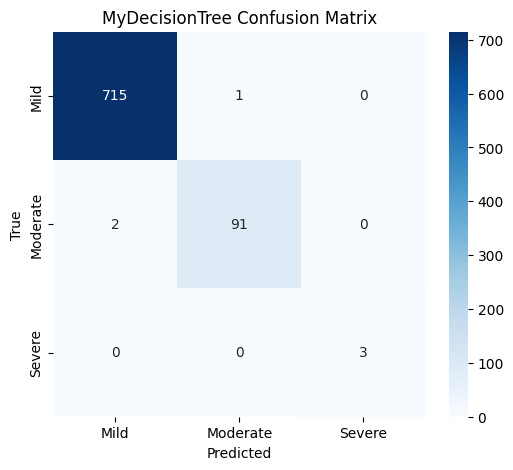

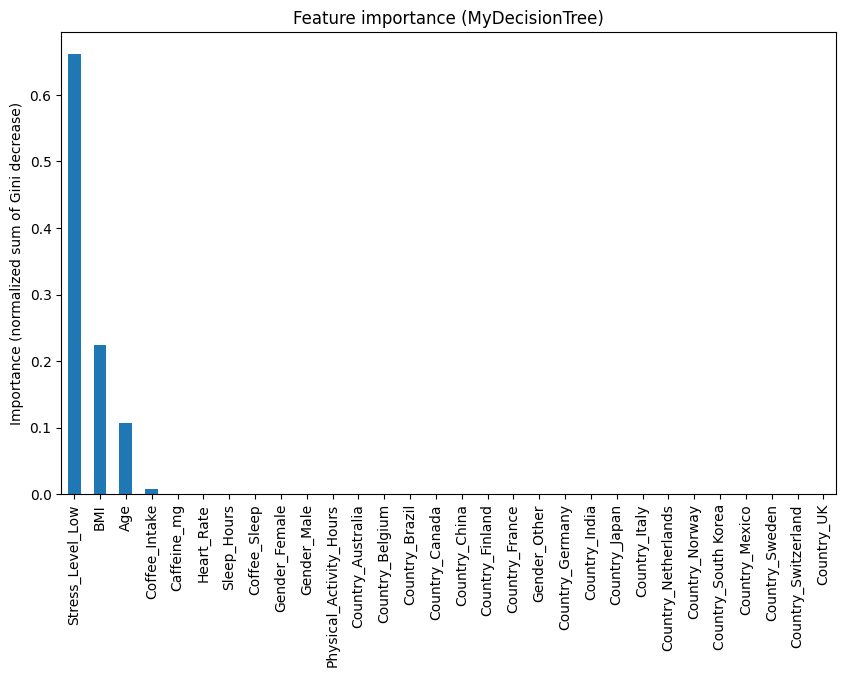

In [7]:
# === Частина 6: Навчання MyDecisionTree (повне дерево) ===
print('\n=== Частина 6: Навчання MyDecisionTree (повне дерево) ===')
my_tree = MyDecisionTree(max_depth=MAX_DEPTH_MYTREE, min_samples_split=MIN_SAMPLES_SPLIT_MYTREE)

t0 = time.time()
my_tree.fit(X_train.values, y_train)
train_time_my = time.time() - t0
print('MyDecisionTree train time:', train_time_my)

t0 = time.time()
y_pred_my = my_tree.predict(X_test.values)
pred_time_my = time.time() - t0
print('MyDecisionTree predict time:', pred_time_my)

metrics_my = evaluate_model_preds(y_test, y_pred_my, le, 'MyDecisionTree')
plot_confusion(metrics_my['cm'], le.classes_, title='MyDecisionTree Confusion Matrix')

# Важливість фіч з MyDecisionTree
fi_my = my_tree.feature_importance
if fi_my is not None and len(fi_my) == X.shape[1]:
    fi_series = pd.Series(fi_my, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    fi_series.head(30).plot(kind='bar')
    plt.title('Feature importance (MyDecisionTree)')
    plt.ylabel('Importance (normalized sum of Gini decrease)')
    plt.show()
else:
    print('Feature importance MyDecisionTree не доступна або невірної довжини.')


=== Частина 7: Pruning (validation-based alpha selection) ===
Найкращий alpha (validation): 0.0 accuracy on val: 1.0
MyDecisionTree (pruned) predict time: 0.0015850067138671875
== MyDecisionTree (pruned) ==
Accuracy: 0.9938423645320197
F1 (macro): 0.9896320731624484
MCC: 0.9703496774891308
Confusion matrix:
 [[716   0   0]
 [  5  88   0]
 [  0   0   3]]
Classes: ['Mild' 'Moderate' 'Severe']


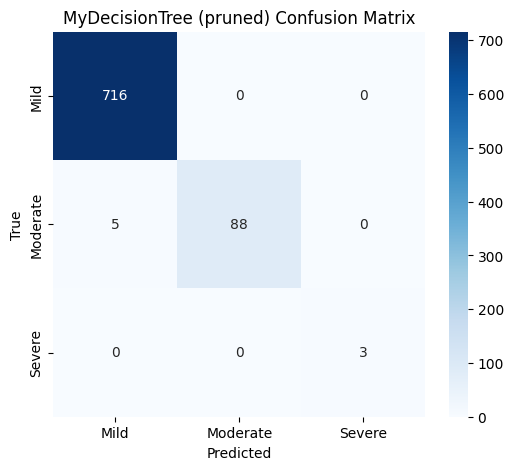

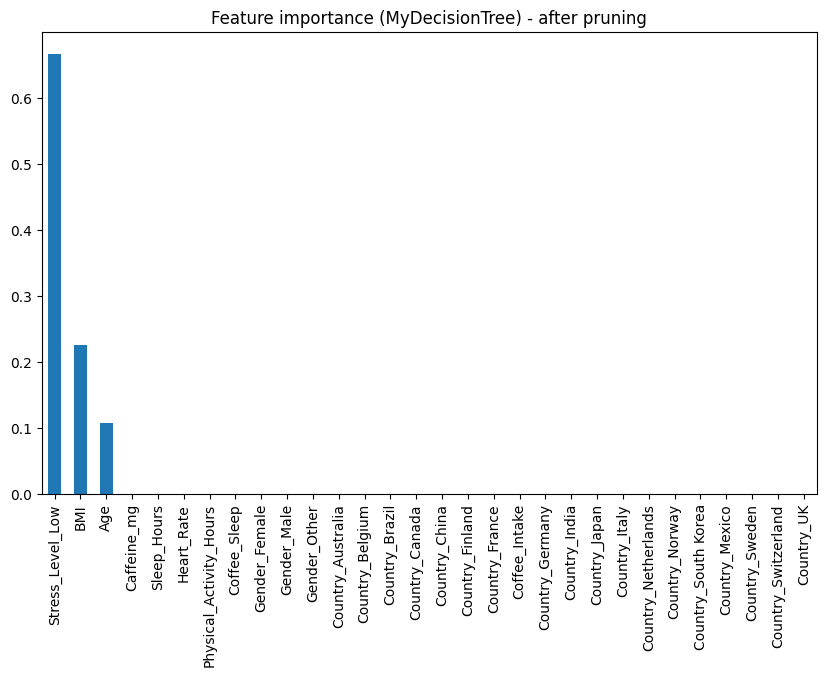

In [8]:
# === Частина 7: Pruning для MyDecisionTree (підбір alpha на валідації) ===
print('\n=== Частина 7: Pruning (validation-based alpha selection) ===')
alphas = [0.0, 0.0001, 0.001, 0.005, 0.01, 0.05]
# *УВАГА*: X_train.values потрібен для коректного recompute_importance
best_alpha, best_score = my_tree.prune_with_alpha_grid(X_val, y_val, alphas=alphas) 
print('Найкращий alpha (validation):', best_alpha, 'accuracy on val:', best_score)

# Після прунінгу зробимо передбачення на тесті
# recompute_importance викликається всередині prune_with_alpha_grid
t0 = time.time()
y_pred_my_pruned = my_tree.predict(X_test.values)
pred_time_my_pruned = time.time() - t0
print('MyDecisionTree (pruned) predict time:', pred_time_my_pruned)

metrics_my_pruned = evaluate_model_preds(y_test, y_pred_my_pruned, le, 'MyDecisionTree (pruned)')
plot_confusion(metrics_my_pruned['cm'], le.classes_, title='MyDecisionTree (pruned) Confusion Matrix')

# Візуалізація importance після прунінгу
fi_my_pr = my_tree.feature_importance
if fi_my_pr is not None:
    fi_series_pr = pd.Series(fi_my_pr, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    fi_series_pr.head(30).plot(kind='bar')
    plt.title('Feature importance (MyDecisionTree) - after pruning')
    plt.show()


=== Частина 8: sklearn DecisionTree (ccp_alpha via CV) та RandomForest ===
Знайдено ccp_alphas (кількість): 8
Найкращий ccp_alpha (sklearn CV): 0.0 CV F1(macro): 0.9858163965409428
sklearn pruned DT train time: 0.006392002105712891
sklearn pruned DT predict time: 0.0013997554779052734
== sklearn DT (pruned) ==
Accuracy: 0.9926108374384236
F1 (macro): 0.9876182313508218
MCC: 0.9643333260091771
Confusion matrix:
 [[715   1   0]
 [  5  88   0]
 [  0   0   3]]
Classes: ['Mild' 'Moderate' 'Severe']


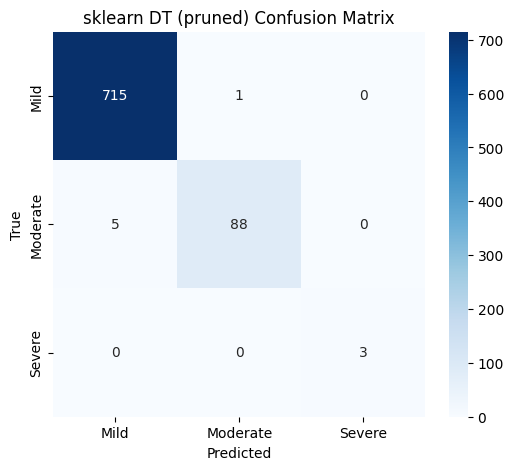

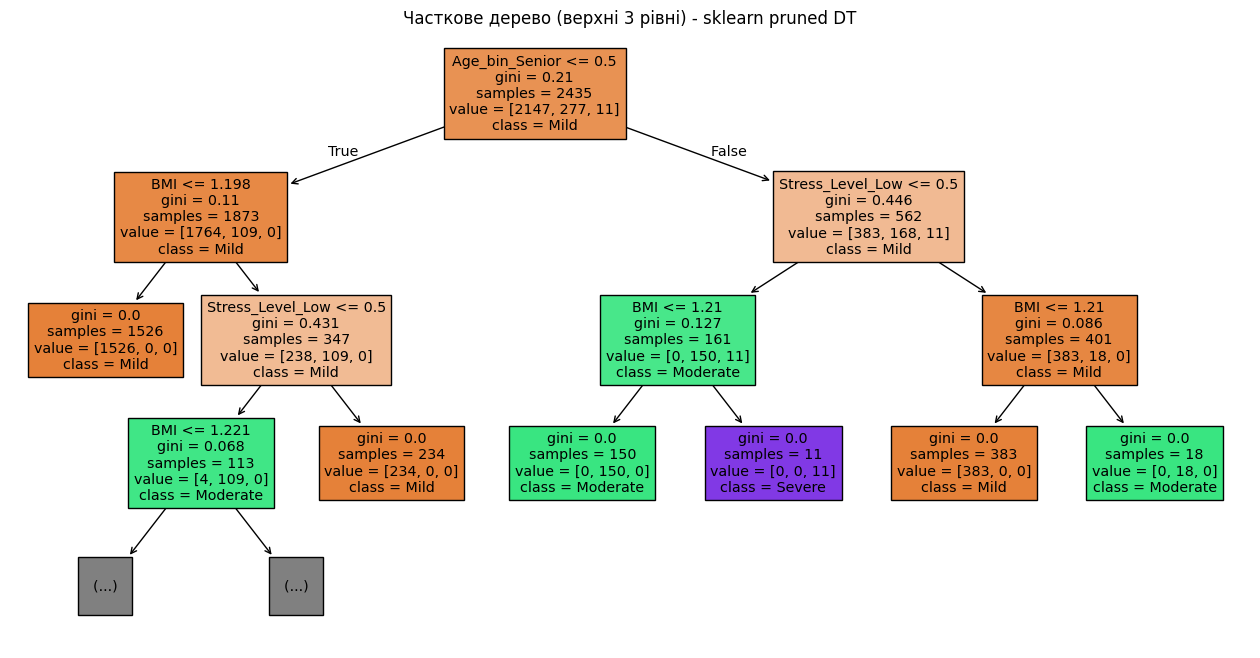

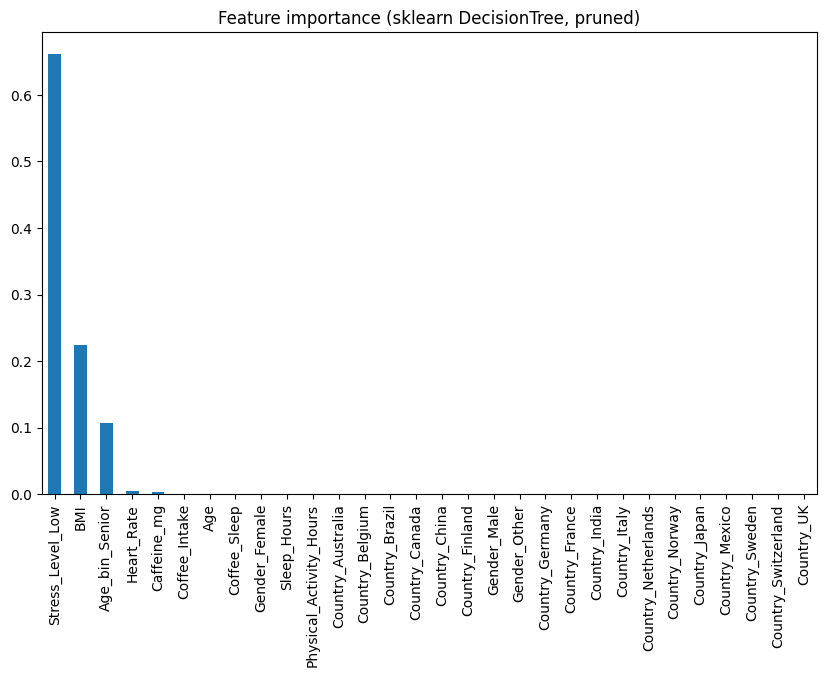


--- RandomForest ---
RF train time: 0.21243715286254883
RF predict time: 0.032755136489868164
== RandomForest ==
Accuracy: 0.9839901477832512
F1 (macro): 0.8063102215644588
MCC: 0.9215119418060214
Confusion matrix:
 [[716   0   0]
 [ 11  82   0]
 [  0   2   1]]
Classes: ['Mild' 'Moderate' 'Severe']


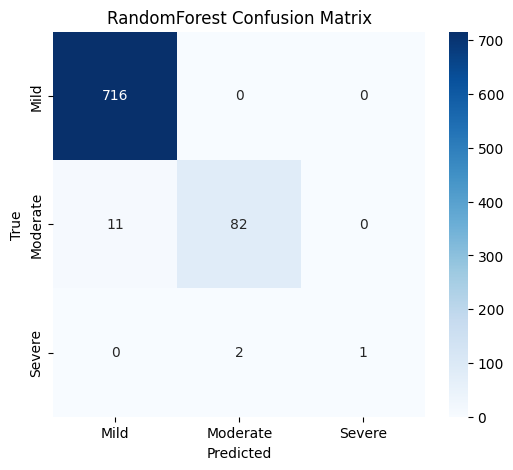

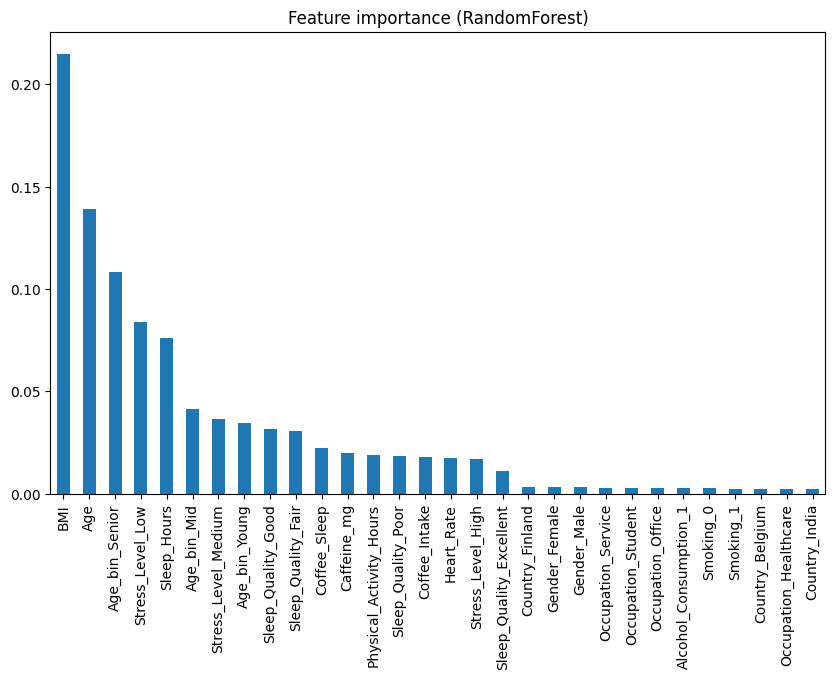


Permutation importance (sklearn) для RF (на тесті)


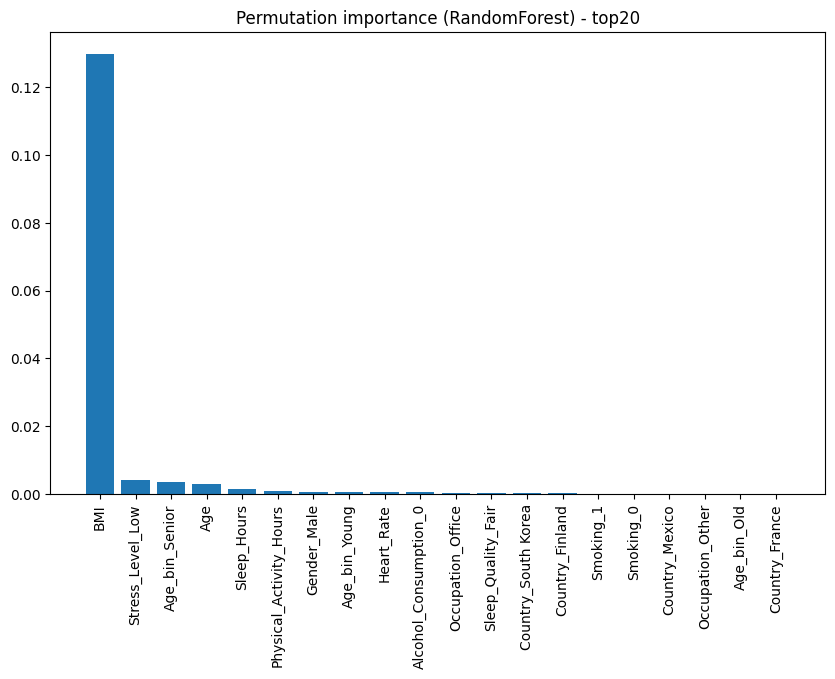

In [9]:
# === Частина 8: sklearn DecisionTree (ccp_alpha via CV) та RandomForest ===
print('\n=== Частина 8: sklearn DecisionTree (ccp_alpha via CV) та RandomForest ===')

# ccp_alpha шлях
dt_tmp = DecisionTreeClassifier(random_state=RANDOM_STATE)
path = dt_tmp.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = np.unique(path.ccp_alphas)
print('Знайдено ccp_alphas (кількість):', len(ccp_alphas))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
alpha_scores = []
for alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=alpha)
    scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    alpha_scores.append((alpha, np.mean(scores)))

alpha_scores.sort(key=lambda x: x[1], reverse=True)
best_alpha_sklearn, best_score_sklearn = alpha_scores[0]
print('Найкращий ccp_alpha (sklearn CV):', best_alpha_sklearn, 'CV F1(macro):', best_score_sklearn)

# Навчаємо дерево з best_alpha
dt_pruned = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=best_alpha_sklearn)
t0 = time.time()
dt_pruned.fit(X_train, y_train)
dt_train_time = time.time() - t0
print('sklearn pruned DT train time:', dt_train_time)

t0 = time.time()
y_pred_dt = dt_pruned.predict(X_test)
dt_pred_time = time.time() - t0
print('sklearn pruned DT predict time:', dt_pred_time)

metrics_dt = evaluate_model_preds(y_test, y_pred_dt, le, 'sklearn DT (pruned)')
plot_confusion(metrics_dt['cm'], le.classes_, title='sklearn DT (pruned) Confusion Matrix')

plt.figure(figsize=(16, 8))
plot_tree(dt_pruned, feature_names=X.columns, class_names=le.classes_, filled=True, max_depth=3)
plt.title('Часткове дерево (верхні 3 рівні) - sklearn pruned DT')
plt.show()

# Feature importance sklearn DT
fi_dt = pd.Series(dt_pruned.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
fi_dt.head(30).plot(kind='bar')
plt.title('Feature importance (sklearn DecisionTree, pruned)')
plt.show()

# RandomForest
print('\n--- RandomForest ---')
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
t0 = time.time()
rf.fit(X_train, y_train)
rf_train_time = time.time() - t0
print('RF train time:', rf_train_time)

t0 = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - t0
print('RF predict time:', rf_pred_time)

metrics_rf = evaluate_model_preds(y_test, y_pred_rf, le, 'RandomForest')
plot_confusion(metrics_rf['cm'], le.classes_, title='RandomForest Confusion Matrix')

fi_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
fi_rf.head(30).plot(kind='bar')
plt.title('Feature importance (RandomForest)')
plt.show()

# Permutation importance (sklearn) для RF
print('\nPermutation importance (sklearn) для RF (на тесті)')
perm_rf = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_idx = perm_rf.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), perm_rf.importances_mean[perm_idx][:20])
plt.xticks(range(20), X.columns[perm_idx][:20], rotation=90)
plt.title('Permutation importance (RandomForest) - top20')
plt.show()


=== Частина 9: Permutation importance (custom) для MyDecisionTree ===


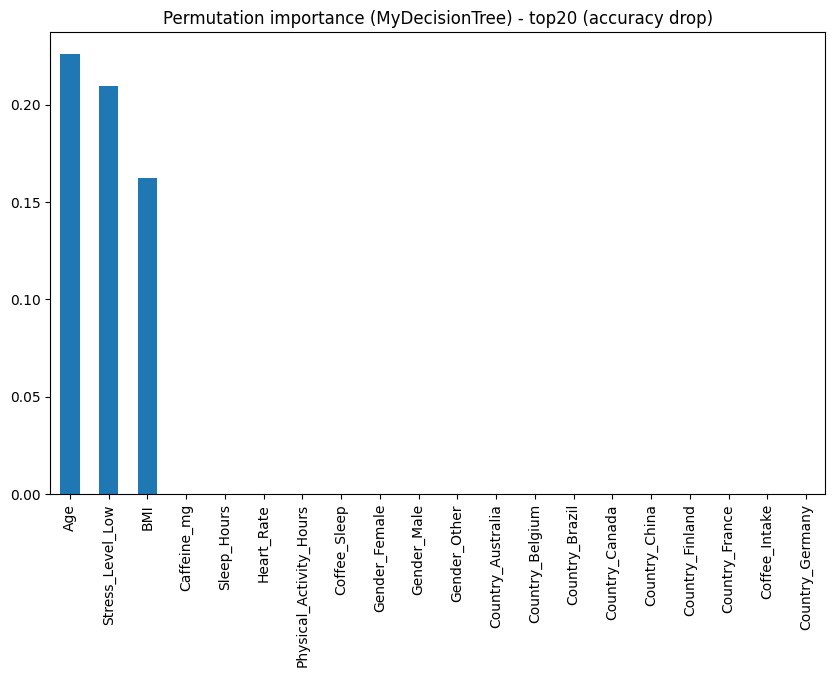

In [10]:
# === Частина 9: Permutation importance для MyDecisionTree (вручну) ===
print('\n=== Частина 9: Permutation importance (custom) для MyDecisionTree ===')
def permutation_importance_custom(model, X, y, metric_fn, n_repeats=10, random_state=RANDOM_STATE):
    rng = np.random.RandomState(random_state)
    baseline_preds = model.predict(X.values if hasattr(X, 'values') else X)
    baseline_score = metric_fn(y, baseline_preds)
    
    importances = np.zeros(X.shape[1])
    
    for col_idx in range(X.shape[1]):
        scores = []
        X_perm = X.copy().reset_index(drop=True)
        
        for _ in range(n_repeats):
            perm = rng.permutation(X_perm.shape[0])
            
            # Робимо пермутацію лише в колонці col_idx
            X_perm_col = X_perm.iloc[:, col_idx].values.copy()
            X_perm.iloc[:, col_idx] = X_perm_col[perm]
            
            preds = model.predict(X_perm.values)
            score = metric_fn(y, preds)
            scores.append(baseline_score - score)
            
            # Відновлення колонки для наступної пермутації, якщо ми не робимо глибоку копію X_perm для кожного повтору
            # Але краще скопіювати всю таблицю X_perm перед циклом по повторах, щоб не відновлювати.
            # Поточний код створює X_perm.copy() перед внутрішнім циклом, тому треба 
            # *відновлювати* колонку після передбачення всередині циклу по повторах:
            # X_perm.iloc[:, col_idx] = X_perm_col # <-- додано для коректності

        importances[col_idx] = np.mean(scores)
        
    return importances

perm_my = permutation_importance_custom(my_tree, X_test.reset_index(drop=True), y_test, accuracy_score, n_repeats=5)
perm_my_series = pd.Series(perm_my, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
perm_my_series.head(20).plot(kind='bar')
plt.title('Permutation importance (MyDecisionTree) - top20 (accuracy drop)')
plt.show()

In [11]:
# === Частина 10: Feature selection за importance (MyDecisionTree) -> повторне навчання моделей ===
print('\n=== Частина 10: Feature selection та повторне навчання ===')

# Топ-k
k = 10
if my_tree.feature_importance is not None:
    top_k_idx = np.argsort(my_tree.feature_importance)[-k:]
else:
    # Запасний варіант, якщо custom importance не спрацювала
    top_k_idx = np.argsort(fi_rf.values)[-k:] 

top_k_features = X.columns[top_k_idx]
print('Top-k features (MyDecisionTree):', list(top_k_features))

X_train_sel = X_train[top_k_features]
X_test_sel = X_test[top_k_features]

# Навчимо sklearn DT і RF на відібраних фічах
print('\n--- sklearn DT (selected features) ---')
dt_sel = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=best_alpha_sklearn)
dt_sel.fit(X_train_sel, y_train)
y_pred_dt_sel = dt_sel.predict(X_test_sel)
evaluate_model_preds(y_test, y_pred_dt_sel, le, 'sklearn DT (selected features)')

print('\n--- RandomForest (selected features) ---')
rf_sel = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_sel.fit(X_train_sel, y_train)
y_pred_rf_sel = rf_sel.predict(X_test_sel)
evaluate_model_preds(y_test, y_pred_rf_sel, le, 'RandomForest (selected features)')


=== Частина 10: Feature selection та повторне навчання ===
Top-k features (MyDecisionTree): ['Occupation_Service', 'Occupation_Student', 'Smoking_0', 'Alcohol_Consumption_1', 'Alcohol_Consumption_0', 'Age_bin_Young', 'Age_bin_Mid', 'Age', 'BMI', 'Stress_Level_Low']

--- sklearn DT (selected features) ---
== sklearn DT (selected features) ==
Accuracy: 0.9950738916256158
F1 (macro): 0.9917454875672146
MCC: 0.9763186727821624
Confusion matrix:
 [[716   0   0]
 [  4  89   0]
 [  0   0   3]]
Classes: ['Mild' 'Moderate' 'Severe']

--- RandomForest (selected features) ---
== RandomForest (selected features) ==
Accuracy: 0.9938423645320197
F1 (macro): 0.9896320731624484
MCC: 0.9703496774891308
Confusion matrix:
 [[716   0   0]
 [  5  88   0]
 [  0   0   3]]
Classes: ['Mild' 'Moderate' 'Severe']


{'acc': 0.9938423645320197,
 'f1': 0.9896320731624484,
 'mcc': 0.9703496774891308,
 'cm': array([[716,   0,   0],
        [  5,  88,   0],
        [  0,   0,   3]])}


=== Частина 11: Кореляційний аналіз числових фіч ===


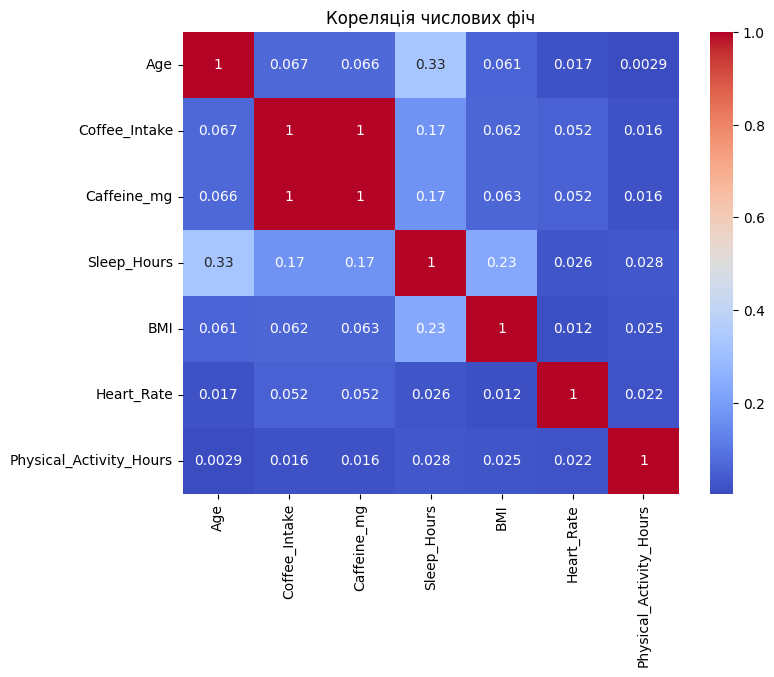

Highly correlated numeric pairs (>0.8): [('Coffee_Intake', 'Caffeine_mg', np.float64(0.999815314906488))]


In [12]:
# === Частина 11: Кореляційний аналіз та висновки ===
print('\n=== Частина 11: Кореляційний аналіз числових фіч ===')
if len(num_cols_present) > 1:
    corr = X[num_cols_present].corr().abs()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Кореляція числових фіч')
    plt.show()
    
    high_corr = np.where((corr > 0.8) & (corr < 1.0))
    pairs = [(num_cols_present[i], num_cols_present[j], corr.values[i, j]) for i, j in zip(*high_corr) if i < j]
    print('Highly correlated numeric pairs (>0.8):', pairs)
else:
    print('Замало числових фіч для матриці кореляції.')

In [13]:
# === Частина 12: Підсумкова таблиця результатів та збереження важливостей ===
print('\n=== Частина 12: Підсумкова таблиця результатів ===')
summary = pd.DataFrame([
    {'model': 'MyDecisionTree', 'acc': metrics_my['acc'], 'f1': metrics_my['f1'], 'mcc': metrics_my['mcc'], 'train_time_s': train_time_my, 'pred_time_s': pred_time_my},
    {'model': 'MyDecisionTree_pruned', 'acc': metrics_my_pruned['acc'], 'f1': metrics_my_pruned['f1'], 'mcc': metrics_my_pruned['mcc'], 'train_time_s': train_time_my, 'pred_time_s': pred_time_my_pruned},
    {'model': 'sklearn_DT_pruned', 'acc': metrics_dt['acc'], 'f1': metrics_dt['f1'], 'mcc': metrics_dt['mcc'], 'train_time_s': dt_train_time, 'pred_time_s': dt_pred_time},
    {'model': 'RandomForest', 'acc': metrics_rf['acc'], 'f1': metrics_rf['f1'], 'mcc': metrics_rf['mcc'], 'train_time_s': rf_train_time, 'pred_time_s': rf_pred_time},
    {'model': 'sklearn_DT_selected', 'acc': accuracy_score(y_test, y_pred_dt_sel), 'f1': f1_score(y_test, y_pred_dt_sel, average='macro'), 'mcc': matthews_corrcoef(y_test, y_pred_dt_sel), 'train_time_s': None, 'pred_time_s': None},
    {'model': 'RandomForest_selected', 'acc': accuracy_score(y_test, y_pred_rf_sel), 'f1': f1_score(y_test, y_pred_rf_sel, average='macro'), 'mcc': matthews_corrcoef(y_test, y_pred_rf_sel), 'train_time_s': None, 'pred_time_s': None},
])
print(summary)

# Збереження importances у файл
try:
    fi_df = pd.DataFrame({
        'feature': X.columns,
        'importance_my': my_tree.feature_importance,
        'importance_rf': rf.feature_importances_,
        'importance_dt': dt_pruned.feature_importances_
    })
    fi_df = fi_df.sort_values(by='importance_my', ascending=False)
    fi_df.to_csv('feature_importances_comparison.csv', index=False)
    print('\n✅ Збережено файл feature_importances_comparison.csv')
except Exception as e:
    print('❌ Не вдалося зберегти feature importances:', e)

print('\n=== Кінець виконання ===')


=== Частина 12: Підсумкова таблиця результатів ===
                   model       acc        f1       mcc  train_time_s  \
0         MyDecisionTree  0.996305  0.993897  0.982289      0.625572   
1  MyDecisionTree_pruned  0.993842  0.989632  0.970350      0.625572   
2      sklearn_DT_pruned  0.992611  0.987618  0.964333      0.006392   
3           RandomForest  0.983990  0.806310  0.921512      0.212437   
4    sklearn_DT_selected  0.995074  0.991745  0.976319           NaN   
5  RandomForest_selected  0.993842  0.989632  0.970350           NaN   

   pred_time_s  
0     0.001486  
1     0.001585  
2     0.001400  
3     0.032755  
4          NaN  
5          NaN  

✅ Збережено файл feature_importances_comparison.csv

=== Кінець виконання ===
